# Optimizacion de una linea

#### Imports

In [39]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from torchvision.transforms import GaussianBlur
from torchmetrics.image import TotalVariation

import torch

from forward_autograd.degradacion import *

#### Data-loading

In [9]:
#x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_real = np.zeros((600,800))
x_real = torch.tensor(x_real)

In [10]:
def T_linea(dim_filas, dim_columnas, x):
    return forward(dim_filas, dim_columnas, x)

In [11]:
def actualizacion_fila_x(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2

In [13]:
def minimizeViaTorch(funcion_objetivo, x0, x_filas, x_columnas, lr=0.1, max_iter=100, eps=1e-6):

    params = x0
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=lr)

    diff = torch.inf

    k = 0

    while (k < max_iter) and (diff > eps):

        print(f"k: {k}, diff: {diff}", end="\r", flush=True)

        params_ant = params.detach().clone()

        optimizer.zero_grad()
        loss = funcion_objetivo(x_filas, x_columnas, params)
        loss.backward(retain_graph=True)
        optimizer.step()

        params_sig = params.detach().clone()

        diff = torch.norm(params_sig - params_ant)

        k += 1

    print("\n\n")

    return params.detach().clone()

#### Objective Function: norm(y - T(x)).

In [51]:
x_img = np.zeros((600,800))
x = torch.tensor(x_img[10,:])

y = T_linea(x_img.shape[0], x_img.shape[1], x)

diff_x = torch.inf
max_iter = 100
eps = 1e-4
lr = 0.1

x = torch.ones_like(x, requires_grad = True)
optimizer = torch.optim.Adam([x], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x(x_img.shape[0], x_img.shape[1], x, y)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    x_next = x.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

k: 0
loss = 1044.8519287109375
diff_x: 2.826612374580955
-----------
k: 1
loss = 1044.842041015625
diff_x: 2.708873638090172
-----------
k: 2
loss = 1044.817138671875
diff_x: 2.167212312645502
-----------
k: 3
loss = 1044.5555419921875
diff_x: 1.6321402569723489
-----------
k: 4
loss = 1094.987548828125
diff_x: 1.4205986270857371
-----------
k: 5
loss = 990.8402709960938
diff_x: 1.2800315998629688
-----------
k: 6
loss = 1368.1944580078125
diff_x: 1.0367093408510686
-----------
k: 7
loss = 1177.8082275390625
diff_x: 1.0591959061376457
-----------
k: 8
loss = 1084.257568359375
diff_x: 0.9684347306770232
-----------
k: 9
loss = 1193.4765625
diff_x: 0.9227862517126955
-----------
k: 10
loss = 1143.5771484375
diff_x: 0.8605151031822649
-----------
k: 11
loss = 1181.67236328125
diff_x: 0.8215551416825687
-----------
k: 12
loss = 1177.8638916015625
diff_x: 0.774546438629378
-----------
k: 13
loss = 1218.42578125
diff_x: 0.7530316078400019
-----------
k: 14
loss = 1205.107177734375
diff_x: 0.

KeyboardInterrupt: 

In [ ]:
y_pred = T_linea(x_img.shape[0], x_img.shape[1], x)
print(y - y_pred)

#### Objective Function: norm(y - T(x)) + lambda*R(x).

In [20]:
lam = 0.1
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

In [15]:
def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

In [48]:
x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
#x_img = np.zeros((600,800))

y = T_linea(x_img.shape[0], x_img.shape[1], x)

diff_x = torch.inf
max_iter = 10000
eps = 1e-6
lr = 0.01

x = torch.randint(0, 256, size=(x_img.shape[1],)).float()
x.requires_grad_()
optimizer = torch.optim.Adam([x], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x, y)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    x_next = x.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

print('x optimo vale:')
print(x_next[:15])

y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
diferencia = y - y_pred

print('la diferencia entre y e y_pred = T(x_optimo) vale:')
print(diferencia[:15])

print('y vale:')
print(y[:15])

print('y_pred vale:')
print(y_pred[:15])

k: 0
loss = 3467.989990234375
diff_x: 0.28277385234832764
-----------
k: 1
loss = 3467.78369140625
diff_x: 0.2827594578266144
-----------
k: 2
loss = 3467.5771484375
diff_x: 0.28274330496788025
-----------
k: 3
loss = 3467.371337890625
diff_x: 0.28272491693496704
-----------
k: 4
loss = 3467.165771484375
diff_x: 0.2827037572860718
-----------
k: 5
loss = 3466.95947265625
diff_x: 0.28268200159072876
-----------
k: 6
loss = 3466.7529296875
diff_x: 0.2826575040817261
-----------
k: 7
loss = 3466.546875
diff_x: 0.28262877464294434
-----------
k: 8
loss = 3466.3408203125
diff_x: 0.282593697309494
-----------
k: 9
loss = 3466.134521484375
diff_x: 0.282548725605011
-----------
k: 10
loss = 3465.9287109375
diff_x: 0.2824968099594116
-----------
k: 11
loss = 3465.722900390625
diff_x: 0.2824327349662781
-----------
k: 12
loss = 3465.515869140625
diff_x: 0.28236326575279236
-----------
k: 13
loss = 3465.31005859375
diff_x: 0.2822919189929962
-----------
k: 14
loss = 3465.10400390625
diff_x: 0.282

KeyboardInterrupt: 

### Prueba formando imagen con linea del vamoo

In [46]:
lam = 0.01
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

In [ ]:
def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

In [47]:
x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
#x_img = np.zeros((600,800))
x = torch.tensor(x_img[10,:])

y = T_linea(x_img.shape[0], x_img.shape[1], x)

diff_x = torch.inf
max_iter = 10000
eps = 1e-6
lr = 0.01

x = torch.ones_like(x, requires_grad = False)
x = x
x.requires_grad_()
optimizer = torch.optim.Adam([x], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x, y)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    x_next = x.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

print('x_true vale:')
print(x_img[10,200:211])

print('x optimo vale:')
x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
print(x_next_norm[200:211])

y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
diferencia = y - y_pred

print('la diferencia entre y e y_pred = T(x_optimo) vale:')
print(diferencia[:15])

print('y vale:')
print(y[200:211])

print('y_pred vale:')
print(y_pred[200:211])

y_obs_total = x_img.clone()
y_obs_total.to(torch.complex64)

y_pred_total = x_img.clone()
y_pred_total.to(torch.complex64)

cant_filas = x_img.shape[0]
for i in range(cant_filas):
    y_pred_total[i,:] = y_pred
    y_obs_total[i,:] = y

/tmp/ipykernel_12805/2484423377.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_img[10,:])


k: 0
loss = 1084.2109814453124
diff_x: 0.2827926549089156
-----------
k: 1
loss = 1084.209637443179
diff_x: 0.28058938253757865
-----------
k: 2
loss = 1084.2077962448413
diff_x: 0.27910878550224727
-----------
k: 3
loss = 1084.2058502798932
diff_x: 0.27594655219846126
-----------
k: 4
loss = 1084.204301187265
diff_x: 0.2721193049143874
-----------
k: 5
loss = 1084.2030321998152
diff_x: 0.2668630096619283
-----------
k: 6
loss = 1084.2010754376108
diff_x: 0.2598730469530696
-----------
k: 7
loss = 1084.1991736451055
diff_x: 0.25177556463303574
-----------
k: 8
loss = 1084.198316057322
diff_x: 0.24395508173551517
-----------
k: 9
loss = 1084.1960714854054
diff_x: 0.23833478726217705
-----------
k: 10
loss = 1084.1941525406528
diff_x: 0.23560376858924081
-----------
k: 11
loss = 1084.191945565203
diff_x: 0.2352345875619716
-----------
k: 12
loss = 1084.1901755261943
diff_x: 0.23610448735996611
-----------
k: 13
loss = 1084.1866332655911
diff_x: 0.2375555853824321
-----------
k: 14
loss =

KeyboardInterrupt: 

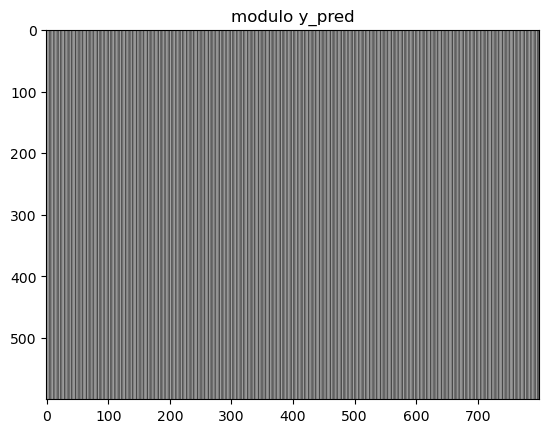

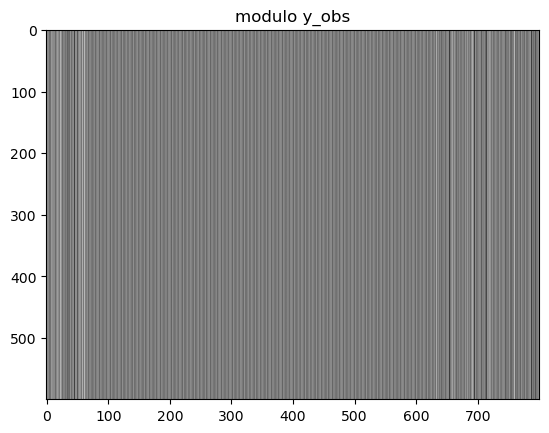

In [ ]:
###tomo modulo

y_pred_total_mod = y_pred_total.abs()
y_obs_total_mod = y_obs_total.abs()

y_pred_total_mod = (y_pred_total - y_pred_total.min())/(y_pred_total.max() - y_pred_total.min())
y_obs_total_mod = (y_obs_total - y_obs_total.min())/(y_obs_total.max() - y_obs_total.min())

plt.imshow(y_pred_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_pred')
plt.show()

plt.imshow(y_obs_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_obs')
plt.show()

In [ ]:
    img_save = torch.zeros((filas, columnas,3))

    img_real = img_salida.real
    img_imag = img_salida.imag

    max_value_real = img_real.max()
    min_value_real = img_real.min()
    max_value_imag = img_imag.max()
    min_value_imag = img_imag.min()

    img_real_normalizado = (img_real - min_value_real)/(max_value_real - min_value_real)
    img_imag_normalizado = (img_imag - min_value_imag)/(max_value_imag - min_value_imag)

    img_save[:,:,0] = img_real_normalizado
    img_save[:,:,1] = img_imag_normalizado

### Prueba formando imagen con linea del ceros

In [ ]:
lam = 10
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

In [ ]:
def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

In [ ]:
#x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_img = torch.zeros((600,800))
x = torch.tensor(x_img[10,:])

y = T_linea(x_img.shape[0], x_img.shape[1], x)

diff_x = torch.inf
max_iter = 10000
eps = 1e-6
lr = 0.1

x = torch.ones_like(x, requires_grad = False)
x = x
x.requires_grad_()
optimizer = torch.optim.Adam([x], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x, y)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    x_next = x.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

print('x_true vale:')
print(x_img[10,200:211])

print('x optimo vale:')
x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
print(x_next_norm[200:211])

y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
diferencia = y - y_pred

print('la diferencia entre y e y_pred = T(x_optimo) vale:')
print(diferencia[:15])

print('y vale:')
print(y[200:211])

print('y_pred vale:')
print(y_pred[200:211])

y_obs_total = x_img.clone()
y_obs_total.to(torch.complex64)

y_pred_total = x_img.clone()
y_pred_total.to(torch.complex64)

cant_filas = x_img.shape[0]
for i in range(cant_filas):
    y_pred_total[i,:] = y_pred
    y_obs_total[i,:] = y

/var/folders/jy/11400q91501_8k9zvcqtlt_w0000gn/T/ipykernel_33404/345487669.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_img[10,:])


k: 0
loss = 81044.8515625
diff_x: 2.8284263610839844
-----------
k: 1
loss = 65844.8515625
diff_x: 2.8167691230773926
-----------
k: 2
loss = 52297.60546875
diff_x: 2.7952210903167725
-----------
k: 3
loss = 40422.6640625
diff_x: 2.761882781982422
-----------
k: 4
loss = 30237.16015625
diff_x: 2.694345474243164
-----------
k: 5
loss = 23009.578125
diff_x: 2.6932179927825928
-----------
k: 6
loss = 16549.6875
diff_x: 2.44351863861084
-----------
k: 7
loss = 8582.373046875
diff_x: 2.36000657081604
-----------
k: 8
loss = 4766.50146484375
diff_x: 2.2472410202026367
-----------
k: 9
loss = 2178.225341796875
diff_x: 2.1106152534484863
-----------
k: 10
loss = 665.7301025390625
diff_x: 1.9502477645874023
-----------
k: 11
loss = 58.89631271362305
diff_x: 1.7673918008804321
-----------
k: 12
loss = 164.82749938964844
diff_x: 1.5646616220474243
-----------
k: 13
loss = 778.7604370117188
diff_x: 1.346046805381775
-----------
k: 14
loss = 1697.434326171875
diff_x: 1.1166894435882568
-----------


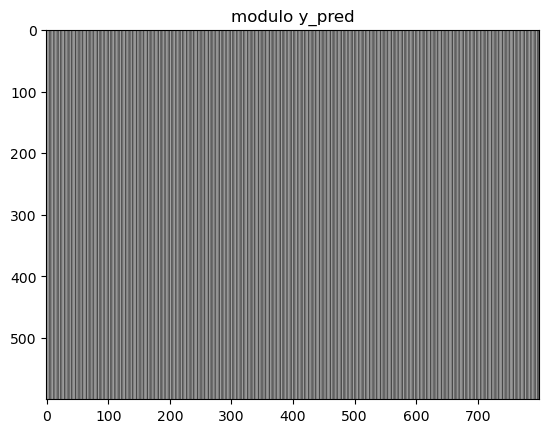

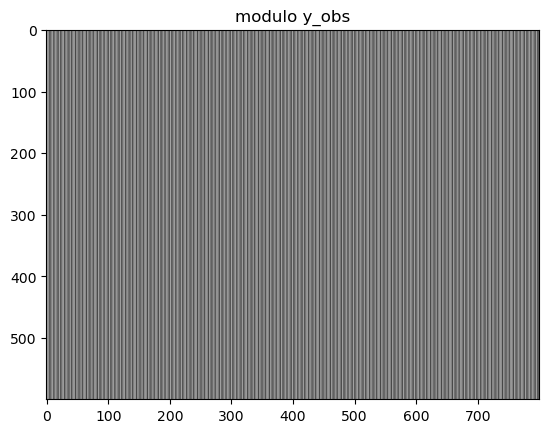

In [ ]:
###tomo modulo

y_pred_total_mod = y_pred_total.abs()
y_obs_total_mod = y_obs_total.abs()

y_pred_total_mod = (y_pred_total - y_pred_total.min())/(y_pred_total.max() - y_pred_total.min())
y_obs_total_mod = (y_obs_total - y_obs_total.min())/(y_obs_total.max() - y_obs_total.min())

plt.imshow(y_pred_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_pred')
plt.show()

plt.imshow(y_obs_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_obs')
plt.show()

## Comparo con resultados de timag

In [ ]:
from degradacionT_timag.degradacion_linea import *

In [ ]:
x_img = np.zeros((600,800))
x = torch.tensor(x_img[10,:])
T_timag = forward(x_img.shape[0], x_img.shape[1], x)

In [ ]:
x_img = np.zeros((600,800))
x = torch.tensor(x_img[10,:])

y = T_linea(x_img.shape[0], x_img.shape[1], x)

diff_x = torch.inf
max_iter = 10
eps = 1e-4
lr = 0.1

x = torch.ones_like(x, requires_grad = True)
optimizer = torch.optim.Adam([x], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x(x_img.shape[0], x_img.shape[1], x, y)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    x_next = x.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_next - x_ant)

    # Asigno la actualizacion
    x = x_next.clone()

    print('-----------')

print("\nTermino!")

In [ ]:
### INICIALIZO VARIABLES ###

mu = 1
sigma2 = 1

diff_x = torch.inf

cant_filas = x_real.shape[0]

###SE VA TRABAJAR CON SOLO UNA LINEA. SE ELIJE LA LINEA 200. SE APILA LA DEGRADACION DE ESA LINEA VARIAS VECES PARA FORMAR IMAGEN y_img###
y_img = x_real.clone()
cant_filas = x_real.shape[0]
fila_200 = T_linea(x_real.shape[0], x_real.shape[1], x_real[200,:])
for i in range(cant_filas):
    y_img[i,:] = fila_200
#x y z se inicializan iguales a y_img
x = uint2tensor4(y_img.clone().detach().numpy())
z = x.clone()
z = uint2tensor4(y_img.clone().detach().numpy())
x_sig_img = x.clone()
x_sig_uint = y_img.clone()
y = y_img[200,:]

### TERMINO DE INICIALIZAR VARIABLES ###

x_filas = x.shape[2]
x_columnas = x.shape[3]

for iter in range(iter_num):
    print(f"Iteracion: {iter}/{iter_num}", end="\r", flush=True)
    print(f"\ndiff_x: {diff_x}")
    
    fila_i_esima = x[0,0,200,:].clone().detach().requires_grad_(True)
    def actualizacion_fila_x(x_filas, x_columnas, x_param_linea):
        return torch.norm(y - T_linea(x_filas, x_columnas, x_param_linea))**2 + mu*sigma2*torch.norm(x_param_linea - z[0,0,200,:])**2
    # Actualizacion de x
    x_opt = minimizeViaTorch(actualizacion_fila_x, x0=fila_i_esima, x_filas = x_filas, x_columnas = x_columnas, lr=1e-4, max_iter=10, eps=1e-5)

    for i in range(cant_filas):
        x_sig_uint[i,:] = x_opt

#PARA QUE CORRA MAS RAPIDO CORRERLO LO DE ARRIBA CON UNA LINEA Y DESPUES DUPLICAR HASTA FORMAR UNA IMAGEN

    x_sig_img = uint2tensor4(x_sig_uint.detach().numpy())

    # Actualizacion de z (.predict de red)
    x_sig_img = torch.cat((x_sig_img, sigmas[iter].float().repeat(1, 1, x_sig_img.shape[2], x_sig_img.shape[3])), dim=1)
    z_sig_img = model(x_sig_img)
    print(z_sig_img.shape)

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_sig_img - x)

    # Asigno la actualizacion
    x = x_sig_img.clone()
    z = z_sig_img.clone()

print("\nTermino!")

Iteracion: 0/8
diff_x: inf
k: 9, diff: 0.00029722091858275235


torch.Size([1, 1, 600, 800])
Iteracion: 1/8
diff_x: 133.99566650390625
k: 9, diff: 0.0010015107691287994


torch.Size([1, 1, 600, 800])
Iteracion: 2/8
diff_x: 31.03072166442871


KeyboardInterrupt: 

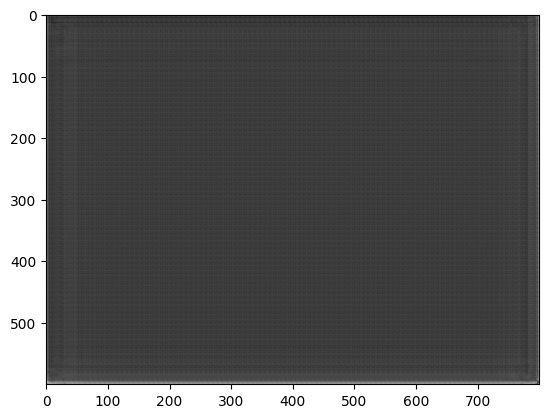

In [ ]:
plt.imshow(z[0,0,:,:],cmap = 'gray')

In [ ]:
x = normalize(x)
z = normalize(z)

NameError: name 'normalize' is not defined

In [ ]:
x = torch.where(x >= 0, x, 0)
x = torch.where(x <= 1, x, 1)

z = torch.where(z >= 0, z, 0)
z = torch.where(z <= 1, z, 1)

TypeError: Invalid shape (800,) for image data

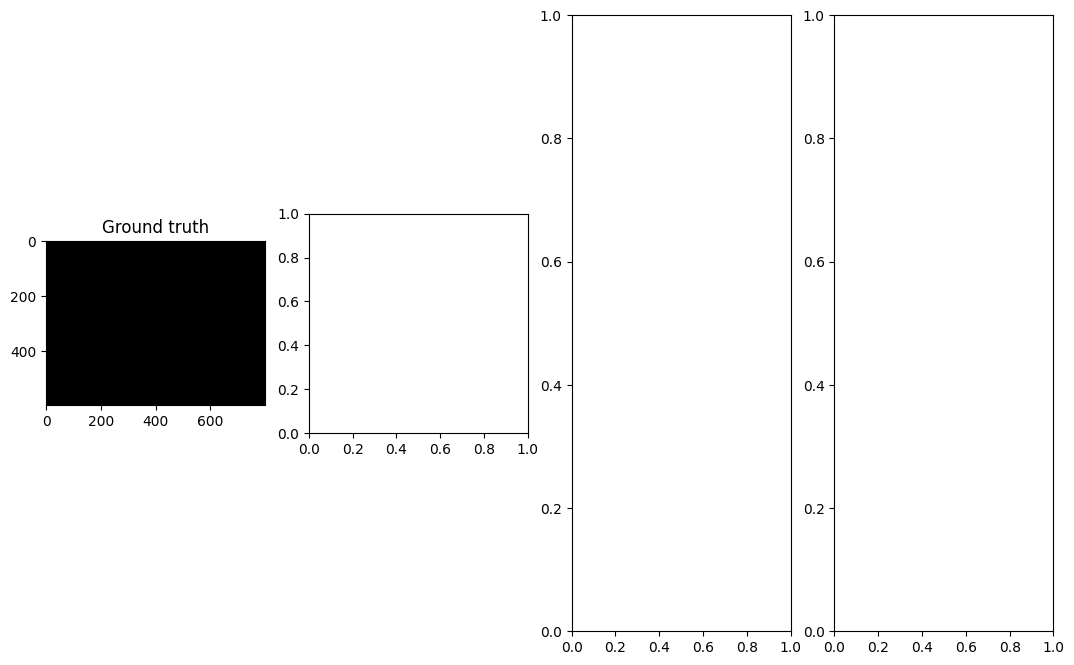

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(13,8))

axs[0].imshow(x_real, cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(y.detach(), cmap="gray")
axs[1].set_title("Degradacion")

axs[2].imshow(x.detach(), cmap="gray")
axs[2].set_title("x")

axs[3].imshow(z.detach(), cmap="gray")
axs[3].set_title("z")

plt.show()


#fig, axs = plt.subplots(1, 4, figsize=(13,8))

#axs[0].imshow(x_real, cmap="gray")
#axs[0].set_title("Ground truth")

#axs[1].imshow(1-y.detach(), cmap="gray")
#axs[1].set_title("Degradacion")

#axs[2].imshow(1-x.detach(), cmap="gray")
#axs[2].set_title("x")

#axs[3].imshow(1-z.detach(), cmap="gray")
#axs[3].set_title("z")

#plt.show()

In [ ]:
print("Ground truth:")
plt.figure(figsize=(10,8))
plt.imshow(x_real, cmap = 'gray')
plt.show()

print("Degradacion:")
plt.figure(figsize=(10,8))
plt.imshow(y.detach(), cmap = 'gray')
plt.show()

print("x:")
plt.figure(figsize=(10,8))
plt.imshow(x.detach(), cmap = 'gray')
plt.show()

print("z:")
plt.figure(figsize=(10,8))
plt.imshow(z.detach(), cmap = 'gray')
plt.show()

In [ ]:
print("x VS x_real")
print("="*30)

print(f"PSNR: {PSNR(x, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(x, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(x, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(x, x_real):0.4f}")

print()

print("y VS x_real")
print("="*30)

print(f"PSNR: {PSNR(y, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(y, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(y, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(y, x_real):0.4f}")

In [ ]:
imsave(f"./imagenes_restauradas/{img_file_name}", x.detach())

In [ ]:
import pandas as pd

In [ ]:
lams = [0, 0.5, 2, 5]
sigmas_energia = [0.01, 0.1, 1, 10]

df = pd.DataFrame(index=range(len(lams)*len(sigmas_energia)), columns=["lambda", "sigma", "PSNR", "SSIM", "MS-SSIM", "IW-SSIM"])

i = 0
for lam in lams:
    for sigma_energia in sigmas_energia:

        # Defino funciones con variables globales
        tv = TotalVariation()

        def f_energia(x):

            return (1/(2*sigma_energia**2)) * torch.norm(y - T_degradacion(x))**2

        def TV(x):

            x = x.unsqueeze(0).unsqueeze(0)

            return lam * tv(x)

        def L1(x):

            return lam * torch.norm(x, p=1)

        def L2(x):

            return lam * torch.norm(x, p=2)**2
        
        def grad_L2(x):

            return 2*lam*x

        def grad_L1(x):

            return lam * np.sign(x)

        def grad_TV(x, eps = 0.1):
            
            x = x.unsqueeze(0).unsqueeze(0)

            grad_x = image_gradients(x)

            norma_gradx = torch.norm(grad_x[0][0,0,:,:])
            norma_grady = torch.norm(grad_x[1][0,0,:,:])

            denominador = torch.sqrt(eps**2 + norma_gradx**2 + norma_grady**2).item()

            cociente_x = grad_x[0] / denominador
            cociente_y = grad_x[1] / denominador
            
            derivada_cociente_x = image_gradients(cociente_x)
            derivada_cociente_y = image_gradients(cociente_y)

            gradiente_tv = derivada_cociente_x[0][0,0,:,:] + derivada_cociente_y[1][0,0,:,:]

            return lam * gradiente_tv
        
        f = f_energia
        h = L2

        grad_h = grad_L2

        cte_h_lipz = 2*lam


        eps = 1e-6
        max_iter = 2_000

        Lz = round(cte_h_lipz + cte_h_lipz**2 + 3) + 1
        beta = max( cte_h_lipz + Lz + 2 , 3*(Lz**2 + cte_h_lipz**2)/((Lz + cte_h_lipz**2)/2) , 3*Lz**2) + 1
        Lx = round(beta + 6*cte_h_lipz**2 + 1) + 1

        diff_x = torch.inf
        diff_z = torch.inf
        diff_gamma = torch.inf

        #x = torch.zeros_like(x_real)
        #z = torch.ones_like(x_real)
        x = y.clone()
        z = x

        Nz = z.shape[0]

        gamma = torch.ones(x.shape)

        mat_inv = torch.from_numpy( np.linalg.inv(Lz + beta*np.identity(Nz)))


        nIter = 1

        while (nIter <= max_iter) and (max(diff_x, diff_z, diff_gamma) > eps):

            print(f"Iteracion: {nIter}/{max_iter}", end="\r", flush=True)
            
            if diff_x > 0:
                
                def actualizacion_x(x_param):

                    return f(x_param) + torch.sum(gamma * x_param) + (Lx/2) * torch.norm(x_param - x)**2 + torch.sum((x_param - x) * (beta*(x - z)))
            
                # Actualizacion de x
                x_sig = minimizeViaTorch(actualizacion_x, x0=x, lr=0.1, max_iter=1_000_000)

            # Actualizacion de z
            z_sig = mat_inv @ (Lz*z - grad_h(z) + gamma + beta*x_sig)
            
            # Actualizacion de gamma
            gamma_sig = gamma + beta*(x_sig - z_sig)

            # Recalculo diferencias entre actualizaciones
            diff_x = torch.norm(x_sig - x)
            diff_z = torch.norm(z_sig - z)
            diff_gamma = torch.norm(gamma_sig - gamma)

            # Asigno la actualizacion
            gamma = gamma_sig
            x = x_sig
            z = z_sig

            nIter += 1

        
        x = torch.where(x >= 0, x, 0)
        x = torch.where(x <= 1, x, 1)

        z = torch.where(z >= 0, z, 0)
        z = torch.where(z <= 1, z, 1)

        psnr_x = PSNR(x, x_real)
        ssim_x = SSIM(x, x_real)
        ms_ssim_x = MS_SSIM(x, x_real)
        iw_ssim_x = IW_SSIM(x, x_real)

        df.iloc[i,:] = [lam, sigma_energia, psnr_x, ssim_x, ms_ssim_x, iw_ssim_x]

        i += 1

In [ ]:
df.head(50)

In [ ]:
plt.figure(figsize=(12,8))

metrica = "IW-SSIM"

for i, sigma_energia in enumerate(sigmas_energia):
    
    df_aux = df.loc[ df.iloc[:,1]==sigma_energia ]
    plt.plot(df_aux.iloc[:,0], df_aux.loc[:,metrica], label=f"$\sigma$: {sigma_energia}")

plt.xlabel(f"$\lambda$")
plt.ylabel(metrica)
plt.grid()
plt.legend()
plt.title(f"Grid-search: {metrica}")
plt.show()